# Исследование данных о продаже комьютерных игр

В нашем распоряжении исторические данные интернет-магазина «Стримчик» — по продажам игр, оценкам пользователей и экспертов, жанрам и платформам, а также географии продаж. Данные представлены за период 1980-2016 гг. (данные за 2016 год могут быть неполными).

Основная цель исследования - выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Общая информация.

Превым шагом испортируем датафрейм и познакомимся с параметрами и структурой данных:

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
# познакомимся со структурой данных
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# выведем основную информацию для анализа типа данных и пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
# посчитаем долю пропусков по стобцам
data.isna().mean().sort_values(ascending=False)

Critic_Score       0.513192
Rating             0.404786
User_Score         0.400897
Year_of_Release    0.016093
Name               0.000120
Genre              0.000120
Platform           0.000000
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
dtype: float64

**Промежуточный вывод:** 

Исходя из полученной информации мы видим, что в данных присуствуют пропуски (в некоторых столбцах пропущено 40-50% всех значений), также названия столбцов нуждаются в обработке.

## Предобработка данных.

In [6]:
# приведем название столбцов к единому регистру
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Проверим наличие дубликатов:

In [7]:
data.duplicated().sum()

0

Проверим наличие неявных дубликатов:

In [8]:
# проработаем неявные дубликаты
data['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

In [9]:
data['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy', nan], dtype=object)

Дубликаты отсуствуют, идем дальше. Проведем анализ пропусков в данных:

In [10]:
# посчитаем долю пропусков по стобцам
data.isna().sum().sort_values(ascending=False)

critic_score       8578
rating             6766
user_score         6701
year_of_release     269
name                  2
genre                 2
platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
dtype: int64

In [11]:
# начнем со строк, где пропущены названия игр и жанров
data.loc[(data['name'].isna()) | (data['genre'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В этих строках пропущена вся основная информация (название и жанр, данные по продажам и рейтингам). Таких строк всего две - они не повлияют на репрезентативность данных, избавимся от них:

In [12]:
data.drop(axis=0, index=[659, 14244], inplace=True, errors='raise')
data.reset_index(drop=True);

Проведем анализ уникальных значений других столбцов, где присутсвуют пропуски:

In [13]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [14]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [15]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [16]:
data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Пропуски присутствуют в столбцах с рейтингом, оценкой пользователей и критиков - возможно потому, что недавно выпущенные игры еще не успели получить необходимый рейтинг (оценки пользователей и критиков, организации ESRB). Также пропуски в данных о годе выпуска могут свидетельствовать о том, что игра только анонсированна, но не выпущена. 
<br />
<br />
В столбце оценки пользователей также присутствует значение "TBD" - "требует уточнения", вероятно, потому что оценок пользователей слишком мало для конкретной игры, для упрощения анализа данных, заменим эти значения на "NaN".



In [17]:
# заменим значения tbd на nan
data.loc[data["user_score"] == 'tbd', 'user_score'] = np.nan

В столбце с рейтингом ESRB введем дополнительную категорию "N/A", чтобы отобразить пропущенные значения.

In [18]:
data['rating'].fillna(value='N/A', inplace=True)

In [19]:
# check
data['rating'].value_counts()

N/A     6764
E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

In [20]:
# агрегируем данные по играм, по которым еще отсуствуют продажи
no_year = data.loc[(data['year_of_release'].isna()) 
                   & (data['na_sales'] <= 0.01) 
                   & (data['eu_sales'] <= 0.01) 
                   & (data['jp_sales'] <= 0.01) 
                   & (data['other_sales'] <= 0.01)
                  ]
len(no_year)

21

В датасете в 21 строке пропущен год выхода игры, при этом по этим играм также отсуствуют значения продаж.

Величина отсечения продаж в 0,01 была выбрана целенаправленно, т.к. часть игр реализуется по предпродажам (т.е. по играм, которые еще не вышли). Мы фильтруем данные через условие "или" потому что продажи на разных рынках могут стартовать в разное время.
<br />
Такие строки можно исключить из анализа, т.к. они не имеют для нас практической ценности.

In [21]:
data.drop(axis=0, index=no_year.index, inplace=True, errors='raise')
data.reset_index(drop=True);

Следуя здравому смыслу можно предположить, что год выпуска игры зависит от платформы, для которой она выходит (причем, большинство разработчиков стремятся выпустить игры к анонсу нового поколения игровой платформы). 
<br />
Следуя этим принципам, восполним пропуски в данных в зависимости от платформы по медианному году выхода игр для каждой отдельной платформы.

In [22]:
for row in data['platform'].unique():
    data.loc[(data['platform'] == row) & (data['year_of_release'].isna()), 'year_of_release'] = \
    data.loc[(data['platform'] == row), 'year_of_release'].median()

Последним шагом предобработки данных будет изменение типа значений в столбцах:
- year_of_release - целочисленные значения (int) будут более читабельными, чем float.
- user_score - числовой тип данных (float, т.к. оценки не целочисленные) более предпочтителен для математических операций, чем str.

In [23]:
data['year_of_release'] = data['year_of_release'].astype(int)

In [24]:
data['user_score'] = data['user_score'].astype(float)

Несмотря на то, что пропуски в оценках пользователей и критиков составляют до половины всех значений, мы не можем достоверно восполнить их, поэтому будем игнорировать.

Для перехода к исследовательскому анализу данных посчитаем суммарные продажи игр во всех регионах:

In [25]:
data['total_sales'] = data['na_sales'] + data['eu_sales']\
                    + data['jp_sales'] + data['other_sales']

In [26]:
# проверим успешность проведения предобработки данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16692 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16692 non-null  object 
 1   platform         16692 non-null  object 
 2   year_of_release  16692 non-null  int64  
 3   genre            16692 non-null  object 
 4   na_sales         16692 non-null  float64
 5   eu_sales         16692 non-null  float64
 6   jp_sales         16692 non-null  float64
 7   other_sales      16692 non-null  float64
 8   critic_score     8126 non-null   float64
 9   user_score       7583 non-null   float64
 10  rating           16692 non-null  object 
 11  total_sales      16692 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.7+ MB


## Исследовательский анализ данных.

### Динамика выпуска игр за все годы

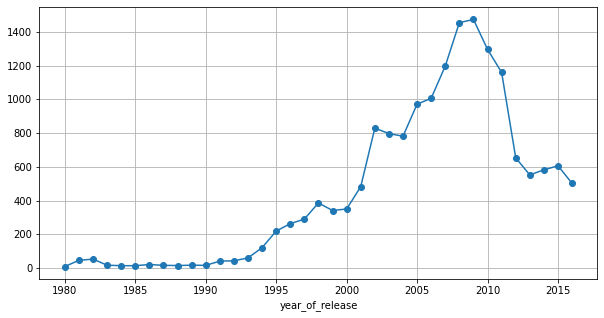

In [27]:
# посмотрим, сколько игр выпускалось в разные годы
data.groupby('year_of_release')['name'].count().plot(style='o-', grid=True, figsize=(10, 5));

Из графика выше следует, что игровой "бум" начался после 1995 года, достигнув максимума в 2008-2009 годах. 
<br />
<br />
Также прослеживается тренд, что игры выпускаются "каскадно" - сразу после презентации новый моделей игровых приставок выходит большинство игр, после этого динамика на несколько лет замедляется (исходя из рыночной экономики будем считать, что основные конкуренты выпускают свои проудкты примерно в один момент времени).

### Динамика продаж по платформам

Посмотрим, как менялись продажи по платформам за все время по ТОП-10 платформам с высокими продажами:

In [28]:
# отфильтруем данные по самым продаваемым платформам в отдельную переменную
top_all_time = data.groupby('platform')['total_sales'].\
    sum().sort_values(ascending=False).head(10)
top_all_time_data = data.query('platform in @top_all_time.index')

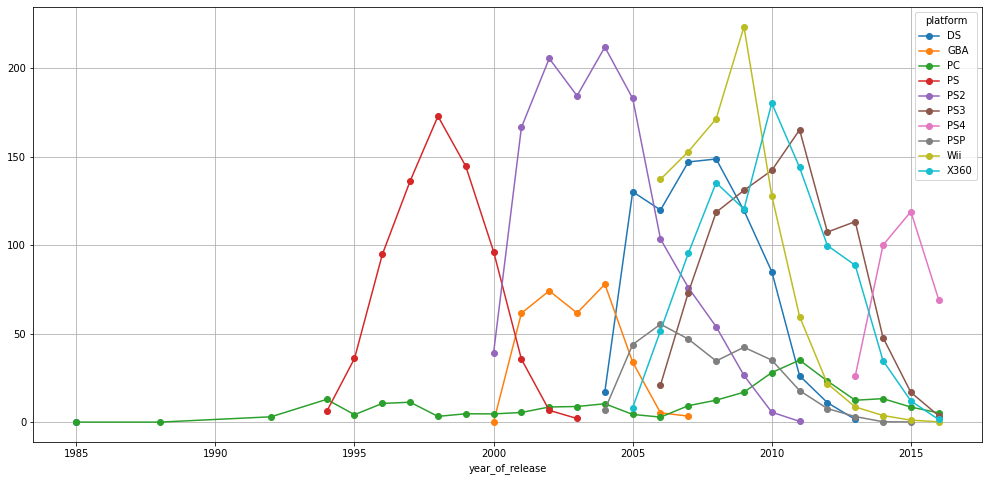

In [29]:
# визуализируем результат
top_all_time_data.pivot_table(
    index='year_of_release', 
    columns='platform', 
    values='total_sales', 
    aggfunc=['sum']
).droplevel(0,axis=1).plot(style='o-', grid=True, figsize=(17, 8));

Судя по графику, средний срок жизни платформы составляет 7-10 лет. Спустя 3-5 лет после анонса платформа достигает пика своей популярности, после чего выходит новая версия этой платформы, и заменяет ее, а старая теряет популярность. 
<br>
<br>
Также на графике видно, что некоторые платформы анонсируются год в год (или год к году друг за другом) - это конкуренция.
<br>
<br>
И еще одна интересная особенность - самый долгий срок жизни у PC, потому что это обобщающее название всех компьютеров (Personal Computer) - первое устройство в истории, которое приспособили для видеоигр, живет до сих пор, но сильно уступает по популярности игровым приставкам.
<br>
<br>
В дальнейшем в нашем исследовании мы можем опираться на данные за период 2004-2016 гг., т.к. это является последним полным циклом жизни популярных платформ предыдущего поколения, также можно проанализировать начало жизненного цикла нового покаления платформ.

### Сравнительный анализ динамики продаж по самым популярным платформам

In [30]:
# отсечем неактуальные исторические данные
last_years_data = data.query('2004 <= year_of_release <= 2016')

In [31]:
# посмотрим на суммарное количество проданных копий на самых популярных платформах за указанный период
last_years_data.groupby('platform')['total_sales'].\
    sum().sort_values(ascending=False)

platform
X360    971.39
PS3     939.63
Wii     907.49
DS      806.07
PS2     660.44
PS4     314.14
PSP     294.04
3DS     259.00
PC      181.91
XOne    159.32
XB      131.42
GBA     120.45
WiiU     82.19
GC       67.97
PSV      54.07
DC        0.06
Name: total_sales, dtype: float64

За период 2004-2016 гг. есть информация о 16 платформах - проанализируем ТОП-10 из них:

In [32]:
# соберем данные по ТОП-10 платформам в отдельную переменную через срез
top_10 = last_years_data.groupby('platform')['total_sales'].\
    sum().sort_values(ascending=False).head(10)
top_10_data = last_years_data.query('platform in @top_10.index')

In [33]:
# соберем данные в сводную таблицу для удобства в дальнейшей работе и визуализируем их
total_sales_top_10 = top_10_data.pivot_table(
    index='year_of_release', 
    columns='platform', 
    values='total_sales', 
    aggfunc=['sum']
).droplevel(0,axis=1)

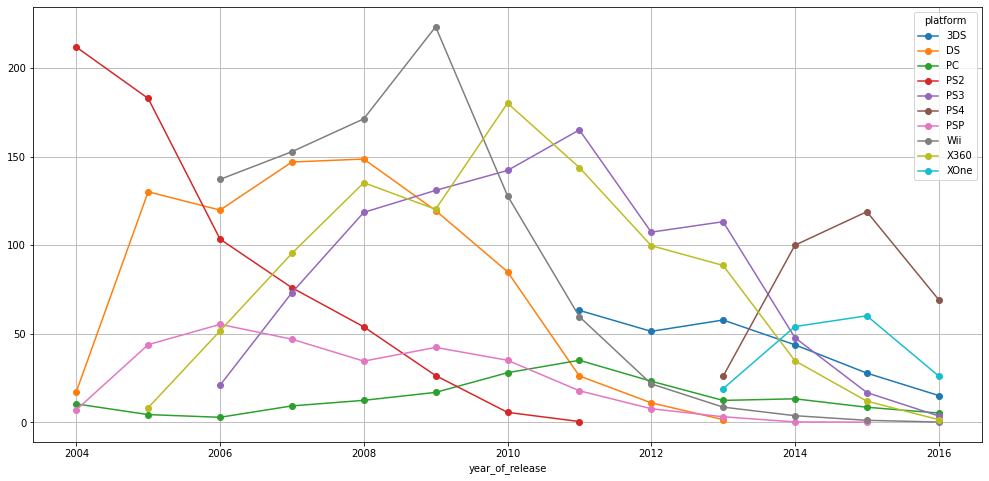

In [34]:
total_sales_top_10.plot(style='o-', grid=True, figsize=(17, 8));

На графике можно выделить несколько лидеров за указанный период, которые представлены несколькими поколениями платформ (последовательные покаления одной платформы, на графике видны их пересечения и замещения):
- PS2 / PS3 / PS4;
- X360 / XOne;
- DS / 3DS;


Наибольшее количество проданных копий продажи за год было у платформы Wii в 2009 году, при этом она имела значительно более резкий спад продаж относительно других популярных платформ, а следующее поколение этой платформы WiiU не обрело достаточной популярности и из-за низких продаж не вошло в ТОП-10 (не отражено на графике).
<br>
<br>
Также на графике можно выделить платформы-лидеры, которые были анонсированы совсем недавно (2011-2013) - 3DS, PS4 и XOne, при этом трудно однозначно сказать, что динамика их роста отличается от лидеров прошлых лет - PS3 и X360 (при условии, что у нас неполные данные за 2016 год).

В дальнейшем для более подробного рассмотрения можно выделить ТОП перспективных платформы - 3DS, PS4 и XOne + PC, поскольку эта платформа имеет исторически длинный жизненный цикл и стабильную аудиторию игроков.

In [35]:
# соберем данные по ТОПовым платформам в отдельную переменную и визуализируем их
top_platforms = data.query('platform in ("3DS", "PS4", "XOne", "PC")')
top_platforms = top_platforms.query('2011 <= year_of_release <= 2015') 

In [36]:
top_platforms_data = top_platforms.pivot_table(
    index='year_of_release', 
    columns='platform', 
    values='total_sales', 
    aggfunc=['sum']
).droplevel(0,axis=1)

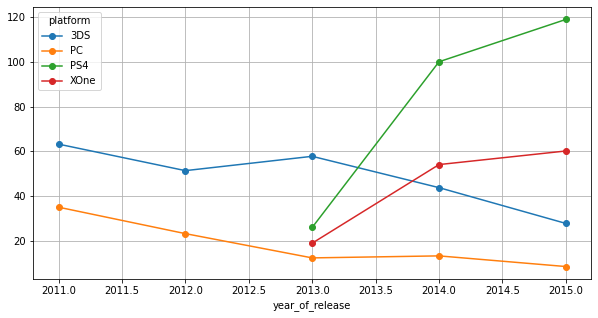

In [37]:
top_platforms_data.plot(style='o-', grid=True, figsize=(10, 5));

Можно отметить, что PS4 потеснила набирающую популярность платформу 3DS (которая была анонсирована за 2 года до PS4). При этом анонсированная в одно время с PS4 платформа XOne в два раза менее популярная (по проданным играм в сравнении с лидером продаж). 

### Анализ распределения данных

In [38]:
# для анализа распределения данных обратимся к "ящику с усами", начнем с параметров
total_sales_top_10.columns

Index(['3DS', 'DS', 'PC', 'PS2', 'PS3', 'PS4', 'PSP', 'Wii', 'X360', 'XOne'], dtype='object', name='platform')

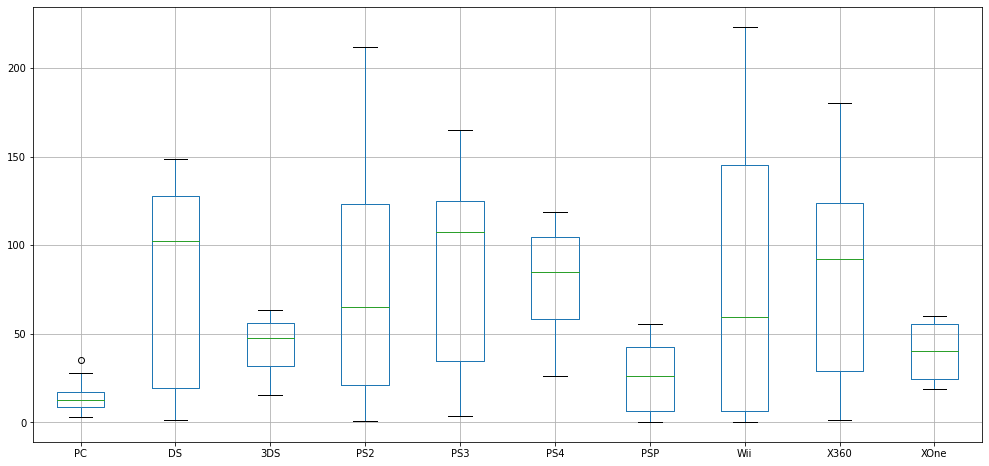

In [39]:
# построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам
total_sales_top_10.boxplot(
    column=['PC', 'DS', '3DS', 
            'PS2', 'PS3', 'PS4', 
            'PSP', 'Wii', 'X360', 'XOne'], 
    grid=True, 
    figsize=(17, 8));

На графике видно, что самыми прибыльными платформами (с наивысшим медианным количеством проданных копий) являются DS, PS3, X360. 

У платформы, имеющей рекорд по количеству проданных копий за год (Wii, 2009), медиана значительно ниже других лидеров рынка. 
<br/>
У платформы PC наблюдается выброс, который можно обьяснить большим разбросом данных из-за длительного присуствия на рынке.

Также сравнивая новые платформы PS4, XOne и 3DS можно сказать, что PS4 более прибыльная, т.к. на этой платформе продается большее количество игр (медиана продаж этой платформы почти вдвое выше, чем у других актуальных конкурентов XOne и 3DS).  

(0.0, 2.0)

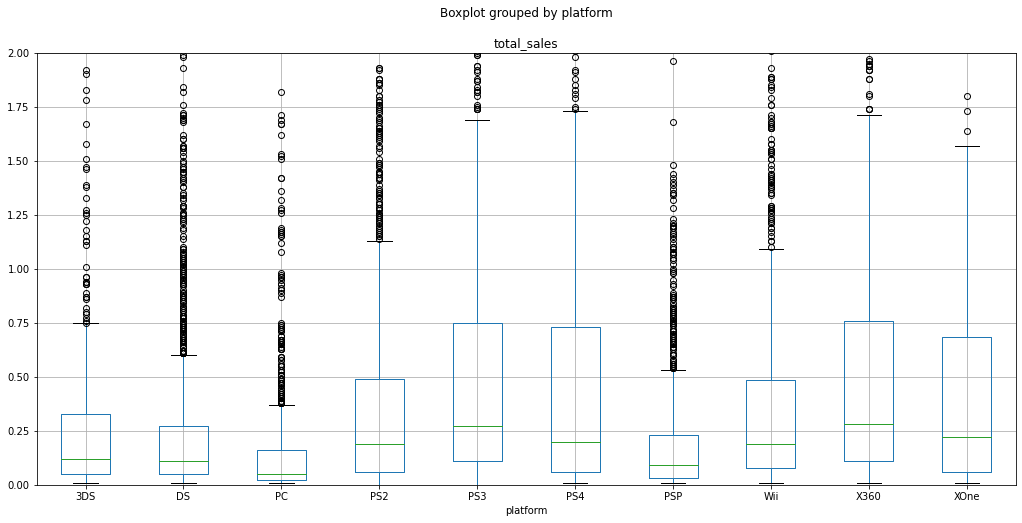

In [40]:
top_10_data.boxplot(column='total_sales', 
                    by='platform', 
                    grid=True, 
                    figsize=(17, 8));
plt.ylim(0, 2)

Согласно диаграмме размаха, самая продаваемая игра вышла на платформе Wii. 

###  Оценка влияния отзывов пользователей и критиков на продажи внутри платформы

Для дальнейшей оценки влияния отзывов пользователей и критиков на количество проданных копий внутри платформы рассмотрим данные платформы PS3, т.к. мы имеем данные по всему жизненному циклу этой платформы.

В пользу выбора PS3 говорит и анализ распределения данных - платформа PS3 имеет наибольшее медианное значение среди прямых конкурентов за 1 промежуток времени, при этом межквартильных размах продаж PS3 меньше, что говорит о более устойчивой динамике продаж и большей популярности в расчете на количество проданных копий.

Также в дополнение мы рассмотрим распределение данных по платформе X360, чтобы верифицировать результат.

In [41]:
# для начала отфильтруем данные по нужной платформе рассчитаем корреляцию показателя продаж относительно отзывов игроков и критиков
ps3_data = data.query('platform == "PS3"')

In [42]:
# рассчитаем корреляцию показателя продаж относительно отзывов игроков
ps3_data['total_sales'].corr(ps3_data['user_score'])

0.12669133936341692

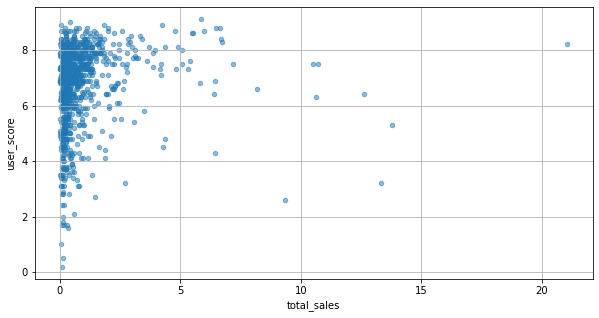

In [43]:
# для визуализации данных построим диаграмму рассеяния 
ps3_data.plot(
    x='total_sales', 
    y='user_score', 
    kind='scatter', 
    alpha=0.5, 
    figsize=(10, 5), 
    grid=True
); 

Если верить коэффициенту корреляции, между оценками пользователей и количеством проданных копий на платформе PS3 очень слабая положительная связь (0.127) - то есть, оценки пользователей влияют на продажи игры, но совсем чуть-чуть (= почти не влияют). 
<br/>
Об этом же нам говорит и диаграмма рассеяния - точки смещены влево и собраны на небольшом интервальном отрезке.

In [44]:
# теперь рассчитаем корреляцию показателя продаж относительно отзывов критиков
ps3_data['total_sales'].corr(ps3_data['critic_score'])

0.4324315685642063

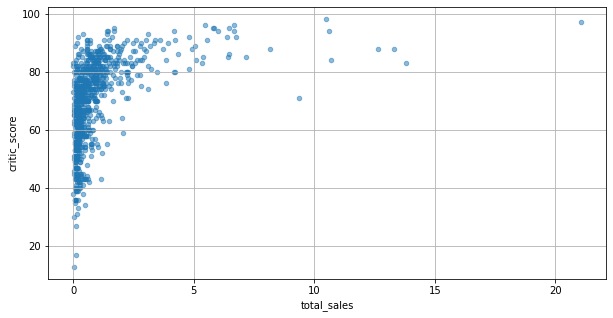

In [45]:
# для визуализации данных построим диаграмму рассеяния 
ps3_data.plot(
    x='total_sales', 
    y='critic_score', 
    kind='scatter', 
    alpha=0.5, 
    figsize=(10, 5), 
    grid=True
); 

Согласно коэффициенту корреляции между оценками критиков и количеством проданных копий на платформе PS3 присутствует более ощутимая положительная связь (0.432), чем между оценками пользователей и количеством проданных копий - пользователи чаще обращают внимание на оценки критиков при покупке игры.
<br/>
Диаграмма рассеяния в данном случае также смещена влево, при этом точки более рассеяны по оси X. 

In [46]:
# для дополнительной верификации проведем анализ по другой популярной платформе
x360_data = data.query('platform == "X360"')

In [47]:
# рассчитаем корреляцию показателя продаж относительно отзывов игроков по второй платформе
x360_data['total_sales'].corr(x360_data['user_score'])

0.11445882978454186

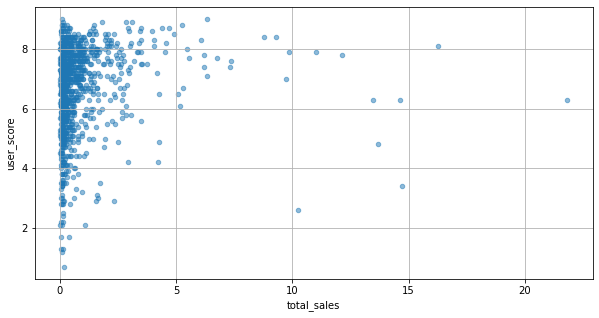

In [48]:
# для визуализации данных построим диаграмму рассеяния 
x360_data.plot(
    x='total_sales', 
    y='user_score', 
    kind='scatter', 
    alpha=0.5, 
    figsize=(10, 5), 
    grid=True
); 

Ситуация скдадывается аналогично - между оценками пользователей и количеством проданных копий на платформе X360 очень слабая положительная связь (0.114) - то есть, оценки пользователей почти не влияют на продажи игр. 
<br/>
Об этом же нам говорит и диаграмма рассеяния - точки смещены влево и имеют небольшой разброс.

In [49]:
# теперь рассчитаем корреляцию показателя продаж относительно отзывов критиков по второй платформе
x360_data['total_sales'].corr(x360_data['critic_score'])

0.3937358653072584

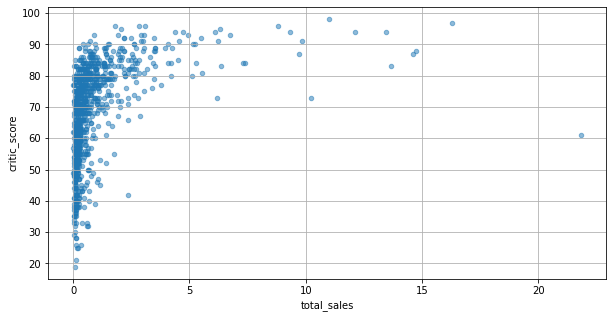

In [50]:
# для визуализации данных построим диаграмму рассеяния 
x360_data.plot(
    x='total_sales', 
    y='critic_score', 
    kind='scatter', 
    alpha=0.5, 
    figsize=(10, 5), 
    grid=True
); 

Между оценками критиков и количеством проданных копий на платформе X360 присутсвует слабая положительная связь, коэффициент корреляции = 0.394 (что ниже, чем аналогичное отношение этих критериев для платформы PS3). Этот вывод подтверждает и диаграмма рассеяния - точки больше распространены по оси X. 
<br/>
Это может говорить о том, что пользователи этой платфорсмы также чаще обращают внимание на оценки критиков при покупке игры. 

**Промежуточный вывод:**

Согласно проведенным расчетам, **оценки пользователей (user_score) практически не имеют влияния на продажи каждой отдельной игры (total_sales)** - об этом нам говорят коэффициенты корреляции, рассчитанные для двух платформ - для PS3 значение корреляции = 0.127, для X360 = 0.114 (очень слабая положительная связь для обеих платформ).

**Оценки критиков (critic_score) имеют более ощутимое влияние на продажи (total_sales), чем оценки пользователей (user_score)** - по расчетам для двух платформ мы видим более ощутимую положительную связь (коэффициенты корреляции для PS3 = 0.432, для X360 = 0.394). Но сила этой связи все еще не настолько большая, чтобы однозначно сказать, что оценки критиков всегда влияют на выбор пользователей. 

По анализу распределения данных и рассчету корреляций для двух самых популярных платформ можно сделать предположение о том, что подобные тренды действительны для всех платформ.

###  Распределение игр по жанрам

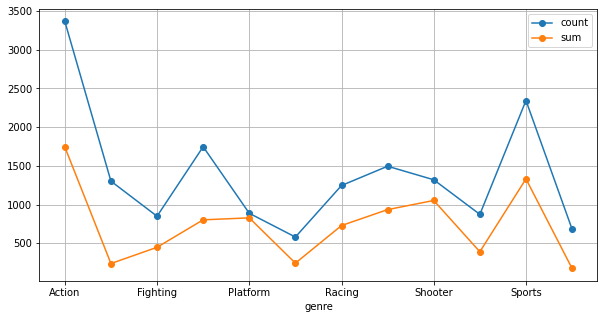

In [51]:
# посчитаем распределение количества игр и проданных копий по жанрам
data.pivot_table(
    index='genre', 
    values='total_sales', 
    aggfunc=['count', 'sum']
).droplevel(1,axis=1).plot(style='o-', grid=True, figsize=(10, 5));

Согласно графику, наиболее распространенные жанры среди игроков - Экшены, Спортивные игры, Аркады (Misc) и Шутеры, 
В экшены пользователи играют в два раза больше, чем в шутеры, а в сравнении с отдельными категориями (Стратегии, Пазлы), экшены популярнее почти в 8 раз.

Зависимость количества выпущенных игр и проданных копий по жанрам чаще линейная, с некоторыми исключениями - в большинстве случаев выполняется условие **"чем популярнее жанр, тем больше проданных копий у игры этого жанра"** (это отражает разница между синими и желтыми точками на графике), но относительно отдельных жанров (Strategy, Adventure, Simulation и др.) оно не выполняется. Вероятно, смещение происходит из-за непопулярности некоторых жанров среди пользователей отдельных рынков.

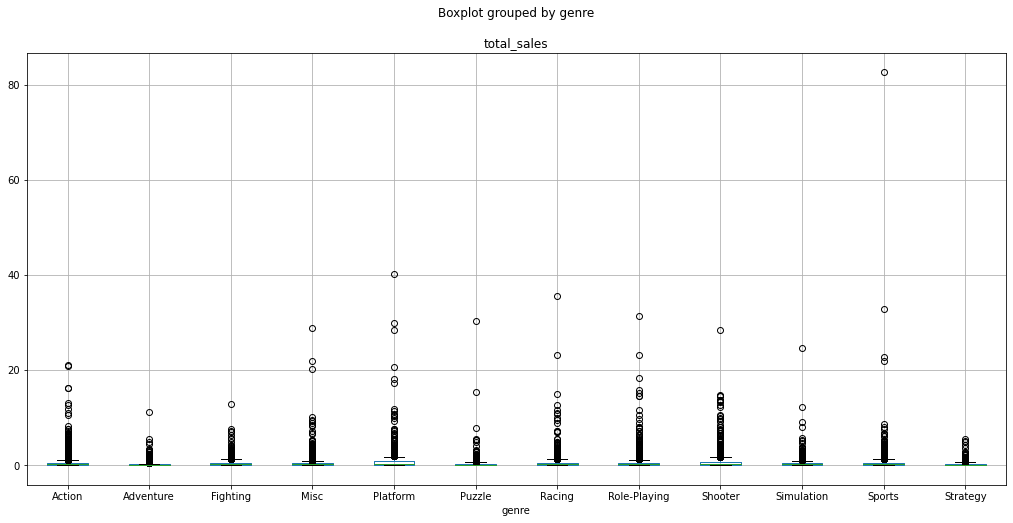

In [52]:
# построим график, чтобы посмотреть на распределение данных
data.boxplot(column='total_sales', 
                    by='genre', 
                    grid=True, 
                    figsize=(17, 8));

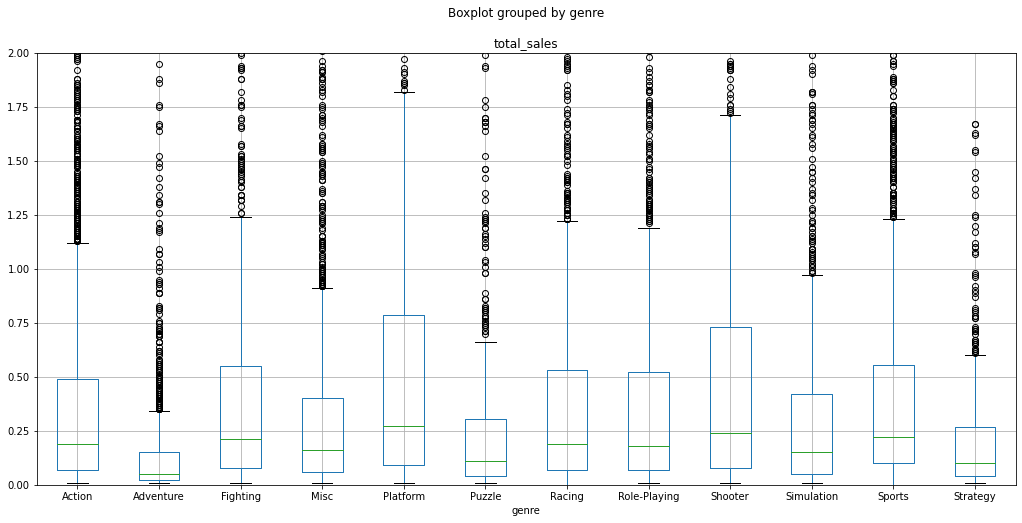

In [53]:
# укажем лимиты, чтобы рассмотреть график подробнее и отсчечь выбросы
data.boxplot(column='total_sales', 
                    by='genre', 
                    grid=True, 
                    figsize=(17, 8));
plt.ylim(0, 2);

Если смотреть на распределение жанров по количеству проданных копий, то лидерами являются такие жанры, как Platform, Shooter и Sports (т.к. медианные значения продаж в этих жанрах самые высокие). 

При этом, судя по хвосту выбросов на диаграмме, наибольшее самая продаваемая игра вышла в жанре Sports, а чаще всего рекордсменами по продажам становятся игры в жанрах - Action, Sports и Role-Playing. 

Жанрами аутсайдерами по продажам являются - Adventure, Puzzle и Strategy. 

## Портрет пользователя по регионам

### Популярность игровых платформ по регионам

Для составления портрета пользователя обратимся к данным за период 2011-2016, которые будут включать в себя только актуальные данные по продажам игр и их распространенности по платформам, что позволит нам выявить нужные тренды.

In [54]:
actual_data = data.query('2014 <= year_of_release <= 2016') 

Для начала составим сводную таблицу с самыми популярными платформами по регионам - поскольку продажи платформ в разных регионах отличаются, придется собрать сводную таблицу вручную:

In [55]:
# агрегируем данные по рынку Северной Америки
na_sales_data = actual_data.pivot_table(
    index='platform',  
    values='na_sales', 
    aggfunc=['mean']
).droplevel(0,axis=1).sort_values(by='na_sales', ascending=False).head()

In [56]:
# агрегируем данные по рынку Европейского Союза
eu_sales_data = actual_data.pivot_table(
    index='platform',  
    values='eu_sales', 
    aggfunc=['mean']
).droplevel(0,axis=1).sort_values(by='eu_sales', ascending=False).head()

In [57]:
# агрегируем данные по рынку Японии
jp_sales_data = actual_data.pivot_table(
    index='platform',  
    values='jp_sales', 
    aggfunc=['mean']
).droplevel(0,axis=1).sort_values(by='jp_sales', ascending=False).head()

In [58]:
# обьединим данные в одну таблицу
platform_by_region = na_sales_data.merge(eu_sales_data, on='platform', how='outer') 
platform_by_region = platform_by_region.merge(jp_sales_data, on='platform', how='outer')

In [59]:
# для того, чтобы визуализировать полученные данные на единой гистограмме избавимся от двухэтажного индекса
platform_by_region = platform_by_region.set_index(
    [pd.Index(
        ['XOne', 'WiiU', 'PS4', 
         'X360', 'Wii', '3DS', 'PS3', 
         'PSV']
    )])

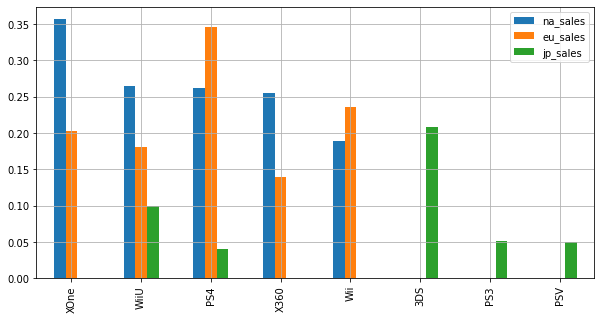

In [60]:
platform_by_region[
    ['na_sales', 'eu_sales', 'jp_sales']
].plot(kind='bar', grid=True, figsize=(10, 5));

Платформы-лидеры по продажам во всех регионах разные. По гистограмме можно сделать несколько однозначных выводов:
- На рынке Северной Америки самой популярной платформой является XOne (платформа компании США - Microsoft);
- Большую долю рынка Европы занимает PS4 (платформа Японской компании - Sony);
- Весь рынок Японии занимают платформы Японских компаний (PS4, PSP, PSV - Sony / 3DS, WiiU - Nintendo); 

- Все игроки предпочитают игровые приставки играм на PC.

Согласно гистограмме, рынки Северной Америки и ЕС схожи по предпочтениям конкретных платформ, но имеют различия в долях их использования. При этом рынок Японии уникальный и практически не пересекается с Северной Америкой и ЕС.

### Популярность игровых жанров по регионам

Проанализируем популярность иговых жанров среди пользователей разных рынков:

In [61]:
# агрегируем данные по рынку Северной Америки
na_genres_data = actual_data.pivot_table(
    index='genre',  
    values='na_sales', 
    aggfunc=['mean']
).droplevel(0,axis=1).sort_values(by='na_sales', ascending=False).head()

In [62]:
# агрегируем данные по рынку Европейского Союза
eu_genres_data = actual_data.pivot_table(
    index='genre',  
    values='eu_sales', 
    aggfunc=['mean']
).droplevel(0,axis=1).sort_values(by='eu_sales', ascending=False).head()

In [63]:
# агрегируем данные по рынку Японии
jp_genres_data = actual_data.pivot_table(
    index='genre',  
    values='jp_sales', 
    aggfunc=['mean']
).droplevel(0,axis=1).sort_values(by='jp_sales', ascending=False).head()

In [64]:
# обьединим данные в одну таблицу
genres_by_region = na_genres_data.merge(eu_genres_data, on='genre', how='outer') 
genres_by_region = genres_by_region.merge(jp_genres_data, on='genre', how='outer')

In [65]:
# для того, чтобы визуализировать полученные данные на единой гистограмме избавимся от двухэтажного индекса
genres_by_region = genres_by_region.set_index(
    [pd.Index(
        ['Shooter', 'Sports', 'Fighting', 
         'Platform', 'Role-Playing', 'Racing', 
         'Simulation', 'Puzzle']
    )])

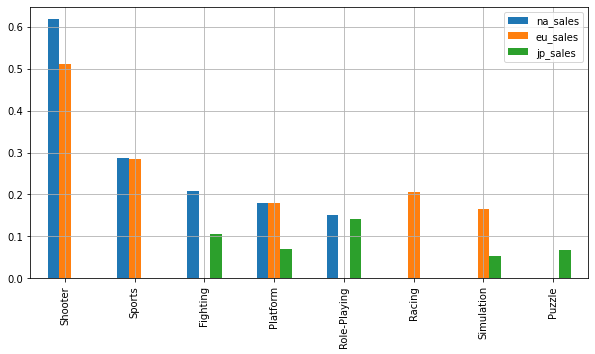

In [66]:
# визуализируем результат вычислений
genres_by_region[
    ['na_sales', 'eu_sales', 'jp_sales']
].plot(kind='bar', grid=True, figsize=(10, 5));

Судя по гистограмме, популярность отдельных игровых жанров различается по рынкам:
- Пользователи Северной Америки и ЕС имеют схожие интересы и предпочитают Шутеры, Платформы, Спортивные игры (совпадают 3 из 5 наиболее популярных жанров);
- Пользователи Японии отдают предпочтение играм с ролевым участием и интеллектуальным играм (в большей степени ненасильственным).
- Рынкок Японии имеет более уникальную структуру и значительно выделяется на фоне предпочтений пользователей Северной Америки и ЕС, последние два рынка более схожи между собой;

### Влияние рейтинга ESRB на продажи по регионам

Самые популярные платформы (топ-5). Опишите различия в долях продаж.
Самые популярные жанры (топ-5). Поясните разницу.
Влияет ли рейтинг ESRB на продажи в отдельном регионе?

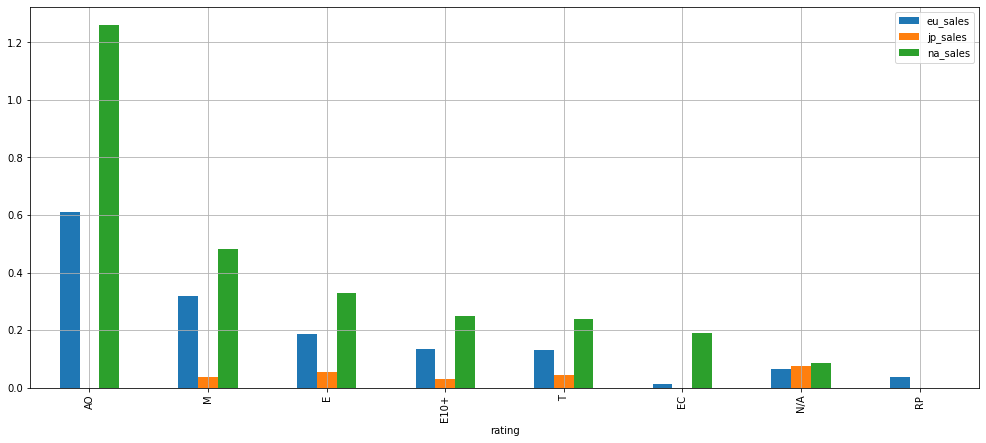

In [67]:
# построим сводную таблицу по рейтингу
last_years_data.pivot_table(
    index='rating',  
    values=['na_sales', 'eu_sales', 'jp_sales'], 
    aggfunc=['mean']
).droplevel(0,axis=1).sort_values(
    by='na_sales', 
    ascending=False
).plot(kind='bar', grid=True, figsize=(17, 7));

Рейтинг игр значительно различается по регионам, по гистограмме можно сделать следующие выводы:
- Игры с рейтингом "AO - Только для взрослых, 18+" наиболее популярны в Северной Америке, в ЕС их популярность в 2 раза ниже, а в Японии такие игры не встречаются совсем;
- Игры с рейтингом "M - Для взрослых, 17+", "E - Для всех", "E10+ - Для всех, старше 10 лет" и "T - Для подростков"  можно встретить на всех исследуемых рынках;
- В Японии значительная доля игр в принципе не имеет рейтинга ESRB, возможно потому, что ESRB это ассоциация США, а на рынке Японии присутсвуют местные ассоциации. Вполне возможно, что локальные издатели игр просто не аккредитовывают свои продукты в ассоциации ESRB.

Прим.: Высота столбцов на графике в данном случае отражает долю продаж, что соответсвует реальной рыночной картине продаж по рынкам.

## Проверка гипотез

### Гипотеза о равенстве пользовательских оценок разных платформ 

Сформулируем гипотезы - нулевую гипотезу исходя из однозначного равенства, а альтернативную гипотезу из неравенства (в таком случае альтернативная гипотеза получится двусторонней, т.к. может откланятся как в большую, так и в меньшую стороны):

```
H_0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые`
H_1: Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые`
alpha = 0.05
```
В этом случае обратимся к методу для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам (scipy.stats.ttest_ind), поскольку нет оснований предполагать, что рейтинги одной платформы могут зависеть от рейтингов другой платформы.

In [68]:
# поскольку платформа XOne анонсирована лишь в 2013 году, уровняем временные отрезки наших выборок
research_data = data.query('2013 <= year_of_release <= 2016')

In [69]:
# подготовим массив оценок пользователей XOne и избавимся от пропусков
x_one = research_data[research_data['platform'] =='XOne']['user_score'].dropna()

In [70]:
# подготовим массив оценок пользователей PC и избавимся от пропусков
pc = research_data[research_data['platform'] =='PC']['user_score'].dropna()

In [71]:
# проведем тест - параметр теста equal_var задаем как False, поскольку выборки разного размера
alpha = .05

results = st.ttest_ind(
    x_one, 
    pc, equal_var = False)

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


Согласно выводу статистического теста, не получилось отвергнуть нулевую гипотезу - значение p-value показывает, что вероятность случайно получить такое или большее различие почти 15%. 
<br/>
Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между пользовательскими рейтингами платформ Xbox One и PC.

###  Гипотеза о равенстве пользовательских оценок разных игровых жанров 

Сформулируем нулевую и альтернативные гипотезы (в этом случае мы также будем проверять двустороннюю альтернативную гипотезу):
```
H_0: Средние пользовательские рейтинги жанров Action и Sports одинаковые`
H_1: Средние пользовательские рейтинги жанров Action и Sports не одинаковые`
alpha = 0.05
```
В этом случае обратимся к методу для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам (scipy.stats.ttest_ind), поскольку нет оснований предполагать, что рейтинги одного игрового жанра могут зависеть от рейтингов другого игрового жанра.

In [72]:
# подготовим массив пользовательские рейтинги жанров Action и избавимся от пропусков
action = data[data['genre'] =='Action']['user_score'].dropna()

In [73]:
# подготовим массив пользовательские рейтинги жанров Sports и избавимся от пропусков
sports = data[data['genre'] =='Sports']['user_score'].dropna()

In [74]:
# проведем тест - параметр теста equal_var задаем как False, поскольку выборки разного размера
alpha = .05

results = st.ttest_ind(
    action, 
    sports, equal_var = False)

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.10560688389918897
Не получилось отвергнуть нулевую гипотезу


Судя по выводу статистического теста, нулевая гипотеза не отвергнута - значение p-value показывает, что вероятность случайно получить такое или большее различие равно 10%, хотя средние пользовательские рейтинги жанров могут быть и не одинаковы. 
<br/>
Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между пользовательскими рейтингами жанров Action и Sports.

## Общий вывод

Для проведения анализа была получена база с данными интернет-магазина «Стримчик», которая включала в себя исторические данные по продажам игр, оценкам пользователей и экспертов, жанрам и платформам, а также географии продаж.

Основная цель исследования заключалась в опеределнии факторов и закономерностей, влияющих на успешность игры, что в дальнейшем позволит определять потенциально популярные продукты и планировать рекламные кампании.
<br />
<br />
В процессе работы над проектом была проведена предобработка данных (заполнение пропущенных значений, анализ аномалий).
<br />
Также был проведен исследовательский анализ данных, который позволил найти интересные особенности и зависимости, которые существуют на  глобальном рынке видеоигр.
<br />
<br />
В процессе иследования были подробно исследованы данные и рассмотренны следующие этапы -
<br />
<br />
**1. Общая характеристика представленных данных.**
<br />
В представленном массиве данных собрана информация о реализации видеоигр за период 1980-2016 гг. по 3 основным рынкам - Северной Америки, Европейского Союза, Японии (и агрегированные данные по остальным странам). В массиве данных представлена информация по разным платформам, которые выпускались за указанный период, а также разнообразным жанрам. Данные отлично отражают периоды зарождения видеоигр (1980-1995 гг.), и их эволюции в отедльный жанр досуга (начиная с 1995 г.), популярный у пользователей, что в дальнейшем пораждает большое разнообразие как самих игр, так и игровых приставок.
<br />
<br />
**2. Исследовательский анализ данных**
<br />
<br />
**2.1. Динамика выпуска игр по годам.**
<br />
Как отмечено ранее, бум развития отрасли видеоигр пришелся на период начиная с 1995 года, когда количество выпускаемых игр год к году начинает расти в арифметической прогрессии. Далее наблюдается эвоционное развитие рынка видеоигр - стремительный рост и развитие конкуренции к середине 2010-хх гг. приобретают циклических характер. 

**2.2. Динамика продаж по платформам.**
<br />
Для оценки динамики продаж по платформам был выбран отдельный временной период (2004-2015 гг.), который отражает полный жизненный цикл отдельных платформ и появление новых покалений этих платформ. 

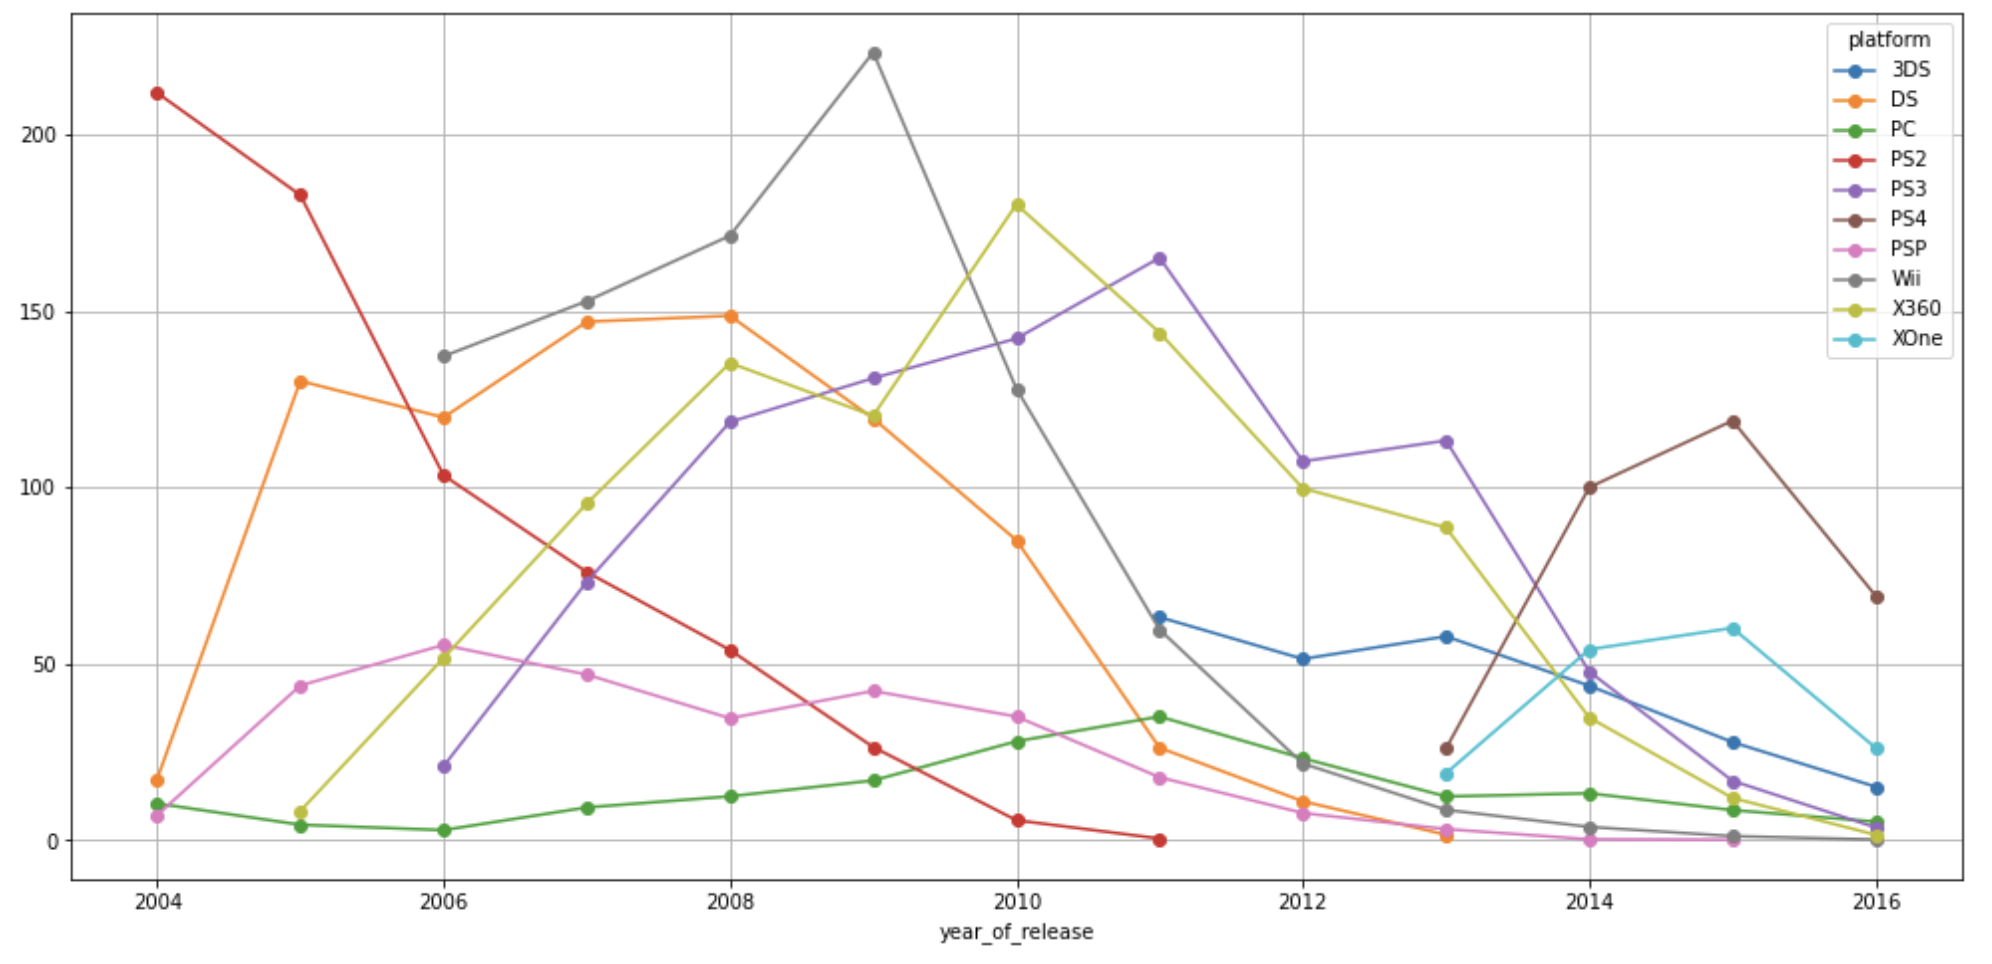

Фактически продажи игр для конкретной игровой платформы и определяют ее жизненный цикл - срок жизни отдельных платформ составляет 7-10 лет с пиком продаж на 3-5 г., после чего продажи по этим платформам падают до 0 и появляются следующие поколения игровых платформ.
<br />
Самыми популярными платформами среди пользователей за всю историю являются Wii, X360, PS3 и DS. 
<br />
<br />
**2.3. Анализ распределения данных.**
<br />
Для анализа распределения данных по ТОП-10 платформам с наибольшими продажами была построена диаграмма "ящик с усами", согласно которой самыми устойчивыми продажами являются PS3 и X360. Из нового поколения платформ лучше продажи показывают PS4 и XOne, продажи на платформе 3DS значительно ниже.

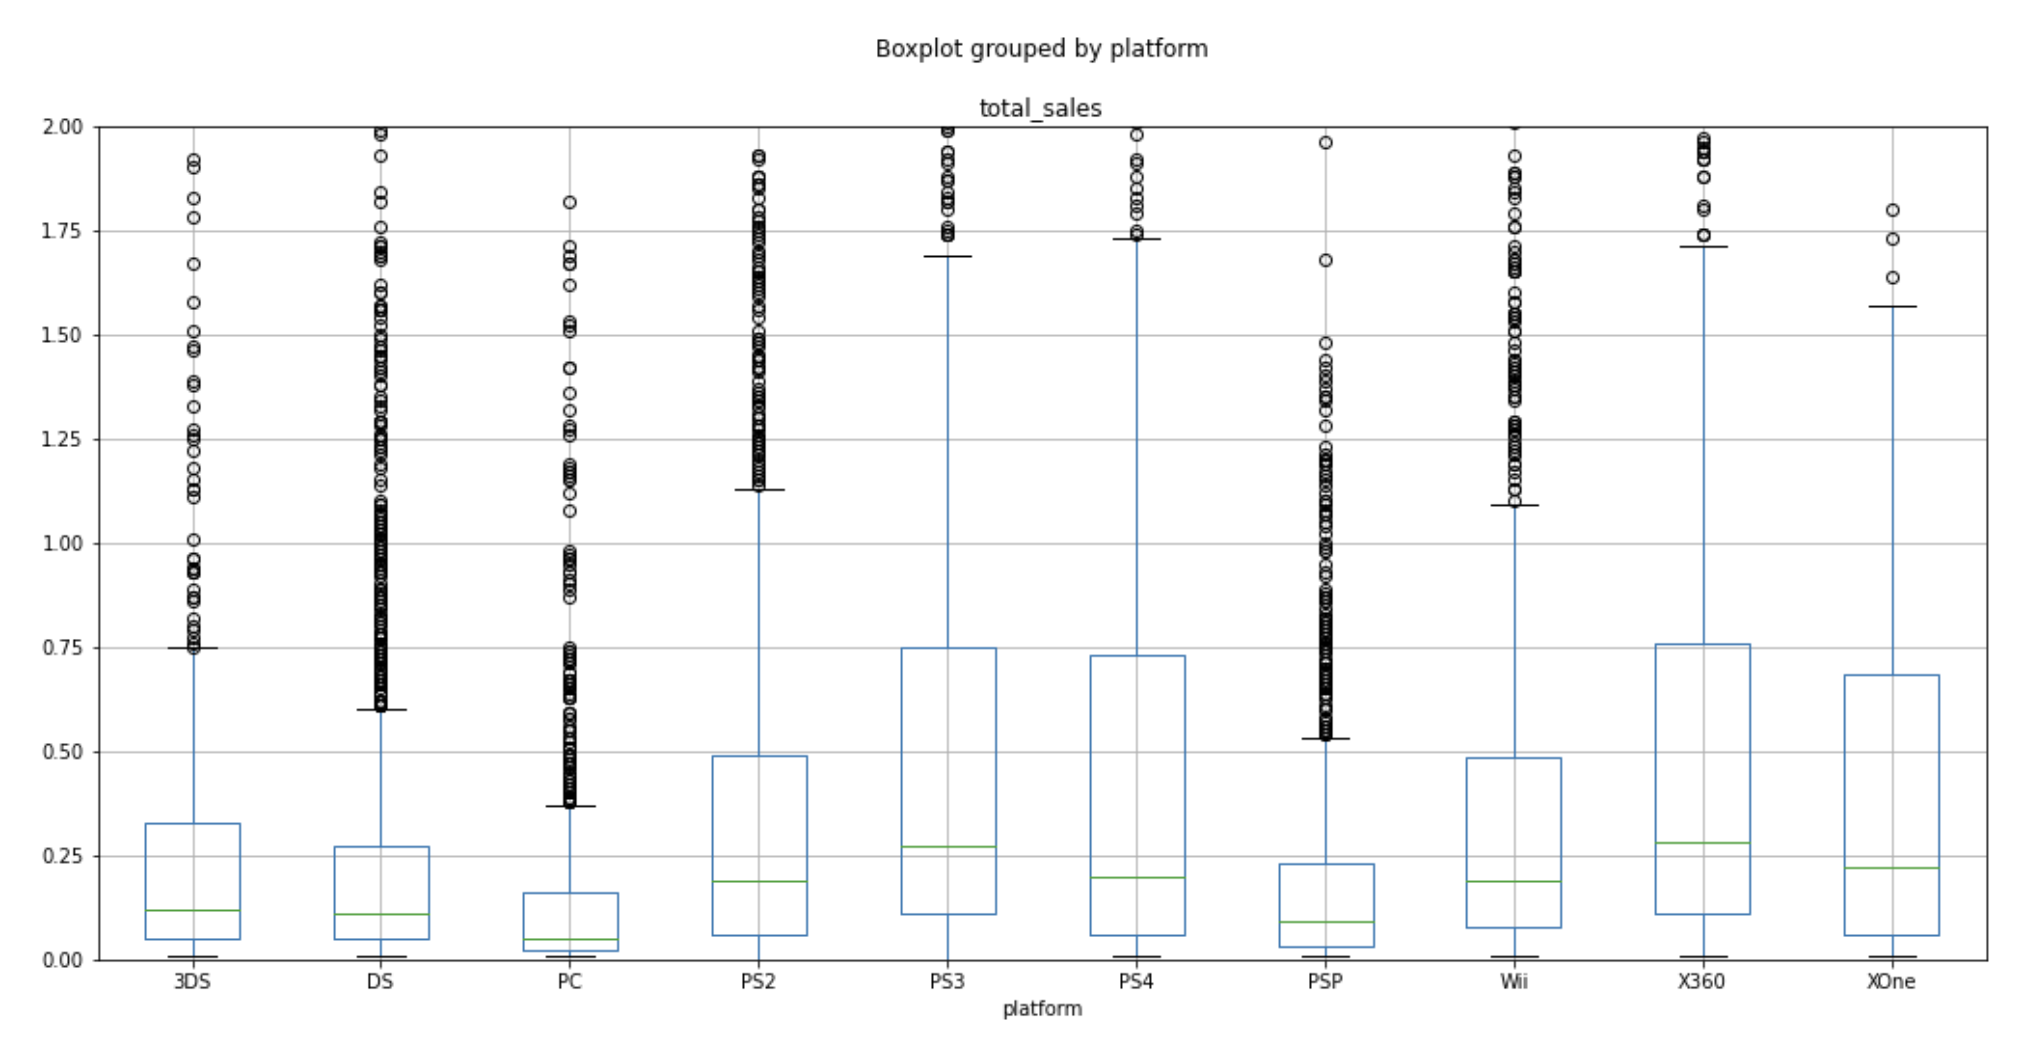

Также можно сделать выводы по продажам игр на новое поколение платформ - при сравнении PS4, XOne и 3DS можно сказать, что PS4 и XOne более прибыльные и перспективные, т.к. на этих платформах продается большее количество игр (медианы продаж вдвое выше, чем у другого актуального конкурента 3DS).
<br />
<br />
**2.4. Оценка влияния отзывов пользователей и критиков на продажи внутри платформы.**
<br />
Для оценки влияния отзывов пользователей и критиков на продажи внутри платформы были рассчитаны корреляционные зависимости этих параметров на примере двух самых популярных игровых (X360 / PS3). Значения корреляции составили:
- <u>0.114 / 0.126</u> соответственно для отношения "Проданных копий / Оценки пользователей";
- <u>0.394 / 0.432</u> соответственно для отношения "Проданных копий / Оценки критиков".

По анализу распределения данных и рассчету корреляций для двух самых популярных платформ можно сделать предположение о том, что подобные тренды действительны для всех платформ.

В данном случае обе величины недостаточны для однозначных выводов, при этом можно сказать, что оценки критиков имеют большее влияние на пользователей при выборе игры, чем оценки других пользователей (оценки пользователей почти не имеют влияния на уровень продажи игры).
<br />
<br />
**2.5. Распределение игр по жанрам.**
<br />
Самая продаваемая игра вышла в жанре Sports, а чаще всего рекордсменами по продажам становятся игры в жанрах - Action, Sports и Role-Playing. 

Жанрами аутсайдерами по продажам являются - Adventure, Puzzle и Strategy.
<br />
<br />
**2.6. Портрет пользователя по регионам:**
<br />
<br />
***Пользователь Северной Америки*** - при выборе игровой платформы чаще всего отдает предпочтение национальному производителю - XOne и X360, Microsoft, и платформам компании Sony - PS4. Вероятно, среднестатистический пользователь этого рынка старше 18 лет, поскольку чаще других предпочитает игры с рейтингом "AO" (18+) в таких жанрах, как: <u> Шутер, Платформы, Поединки, Спортивные игры и гонки </u>;
<br />
<br />
***Пользователь Европейского Союза*** - похож по профилю на пользователя Северной Америки, среди игровых платформ чаще предпочитает продут компании Sony - PS4, также в равной степени другие платформы (X360, Wii). Вероятно, среднестатистический пользователь видеоигр из Европейского Союза также старше 18 лет, поскольку в регионе популярны игры с рейтингом "AO" (18+) в жанрах - <u> Экшен, Шутер, Платформы, Спортивные игры и гонки </u>.
<br />
<br />
***Пользователь Японии*** - по профилю значительно отличается от пользователей Северной Америки и Европы - среди игровых платформ предпочитает продуты национальных производиетелей Nintendo (3DS, WiiU) и Sony (PS4, PSP). Вероятно, среднестатистический пользователь видеоигр из Японии младше 18 лет (ребенок старше 10 лет или подросток до 18), поскольку в регионе в равной степени популярны игры с рейтингом "М" (17+) и EC-EC10+ (10-13+) в ненасильственных игровых жанрах - <u> Платформы, Роул-Плеи, Пазлы, Поединки </u>.
<br />
<br />
**2.7. Влияние рейтинга ESRB на продажи по регионам.**
<br />
Рейтинг оранизации ESRB имеет непосредственное влияние на продажи в отдельных регионах (Северной Америки и ЕС), т.к. большинство игр, продающихся на этом рынке имеют соответствующий рейтинг. При этом большая доля игр на рынке Японии не имеет рейтинга ESRB, и, вероятно, этот рейтинг не особо влияет на прожажи игр на рынке Японии. 

По имеющимся данным можно обобщить, что игроки из Северной Америки и ЕС предпочитают игры 18+, в то время как игроки Японии чаще выбирают игры с маркировкой 17+, 13+, 10+.
<br />
<br />
**3. Проверка гипотез.**
<br />
<br />
***Гипотеза о равенстве пользовательских оценок разных платформ***
<br />
В ходе анализа были определены нулевая и альтернативная гипотезы:
- `H_0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые`
- `H_1: Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые`
<br />
<br />
<u>Нулевая гипотеза не отвергнута</u>.

При проведении статистического теста по методу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам значения p-value составило 0.147, в связи с чем можно сделать вывод, что почти в 15% случаев пользователи платформ Xbox One и PC оставляют играм одинаковые оценки. 
<br />
<br />
***Гипотеза о равенстве пользовательских оценок разных игровых жанров***
<br />
В ходе анализа были определены нулевая и альтернативная гипотезы:
- `H_0: Средние пользовательские рейтинги жанров Action и Sports одинаковые`
- `H_1: Средние пользовательские рейтинги жанров Action и Sports не одинаковые`
<br />
<br />
<u>Нулевая гипотеза не отвергнута</u>.

При проведении статистического теста по методу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам значения p-value составило 0.106,в связи с чем можно сделать вывод, что в 10% случаев есть вероятность случайно получить такие же или еще большие результаты.

**Вывод**

В процессе исследования факторов и закономерностей, влияющих на успешность игры, были выявлены общие черты и различия между среднестатистическими пользователями разных рынков, а также определены связи между оценками игры и ее дальнейшим коммерческим успехом, что в дальнейшем позволит спланировать маркетинговые и продуктовые стратегии для новых игр.
